In [1]:
!pip install transformers
!pip install datasets

## Dataset Load

### 허깅 페이스 데이터셋 처음 사용하기

In [2]:
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datasets import list_datasets
from datasets import load_dataset

from transformers import AutoTokenizer, AutoModel
from transformers import AutoModelForSequenceClassification
from huggingface_hub import notebook_login
from transformers import Trainer, TrainingArguments

In [3]:
all_datasets = list_datasets()
print(f"현재 허브에는 {len(all_datasets)}개의 데이터셋이 있습니다.")
print(f"처음 10개 데이터셋: {all_datasets[:10]}")

<ipython-input-3-f6d89176be90>:1: FutureWarning: list_datasets is deprecated and will be removed in the next major version of datasets. Use 'huggingface_hub.list_datasets' instead.
  all_datasets = list_datasets()


현재 허브에는 45794개의 데이터셋이 있습니다.
처음 10개 데이터셋: ['acronym_identification', 'ade_corpus_v2', 'adversarial_qa', 'aeslc', 'afrikaans_ner_corpus', 'ag_news', 'ai2_arc', 'air_dialogue', 'ajgt_twitter_ar', 'allegro_reviews']


각 데이터셋은 고유한 이름이 있습니다. `load_dataset()` 함수로 `emotion` 데이터셋을 로드해보죠.

In [5]:
emotions = load_dataset("emotion")
emotions

  0%|          | 0/3 [00:00<?, ?it/s]

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 16000
    })
    validation: Dataset({
        features: ['text', 'label'],
        num_rows: 2000
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 2000
    })
})

In [6]:
train_ds = emotions["train"]
print(len(train_ds))
print(train_ds.features['label'])

16000
ClassLabel(names=['sadness', 'joy', 'love', 'anger', 'fear', 'surprise'], id=None)


In [8]:
for i in range(5):
  print(train_ds[i])

{'text': 'i didnt feel humiliated', 'label': 0}
{'text': 'i can go from feeling so hopeless to so damned hopeful just from being around someone who cares and is awake', 'label': 0}
{'text': 'im grabbing a minute to post i feel greedy wrong', 'label': 3}
{'text': 'i am ever feeling nostalgic about the fireplace i will know that it is still on the property', 'label': 2}
{'text': 'i am feeling grouchy', 'label': 3}


### 사이드바: 허브에 필요한 데이터셋이 없다면?

In [ ]:
# dataset_url = "https://www.dropbox.com/s/1pzkadrvffbqw6o/train.txt"
# !wget {dataset_url}

In [ ]:
# !head -n 1 train.txt

In [ ]:
# emotions_local = load_dataset("csv", data_files="train.txt", sep=";",
#                               names=["text", "label"])

In [ ]:
# dataset_url = "https://www.dropbox.com/s/1pzkadrvffbqw6o/train.txt?dl=1"
# emotions_remote = load_dataset("csv", data_files=dataset_url, sep=";",
#                                names=["text", "label"])

# Datasets → DataFram(pandas)

In [9]:
emotions.set_format(type="pandas")
df = emotions["train"][:]
df.head()

,text,label
0,i didnt feel humiliated,0
1,i can go from feeling so hopeless to so damned...,0
2,im grabbing a minute to post i feel greedy wrong,3
3,i am ever feeling nostalgic about the fireplac...,2
4,i am feeling grouchy,3


In [10]:
emotions["train"].features['label'].__class__

datasets.features.features.ClassLabel

In [11]:
def label_int2str(row):
    return emotions["train"].features["label"].int2str(row)

df["label_name"] = df["label"].apply(label_int2str)
df.head()

,text,label,label_name
0,i didnt feel humiliated,0,sadness
1,i can go from feeling so hopeless to so damned...,0,sadness
2,im grabbing a minute to post i feel greedy wrong,3,anger
3,i am ever feeling nostalgic about the fireplac...,2,love
4,i am feeling grouchy,3,anger


### Class 분포 살펴보기
 - class 불균형 문제 방지
 - 소수 클래스 : oversampling
 - 다수 클래스 : undersampling
 - 클래스 대표성부족 : labeled dataset 추가수집

 ※ 다만, train/test 분할 전까지 sampling은 적용하지 말 것.

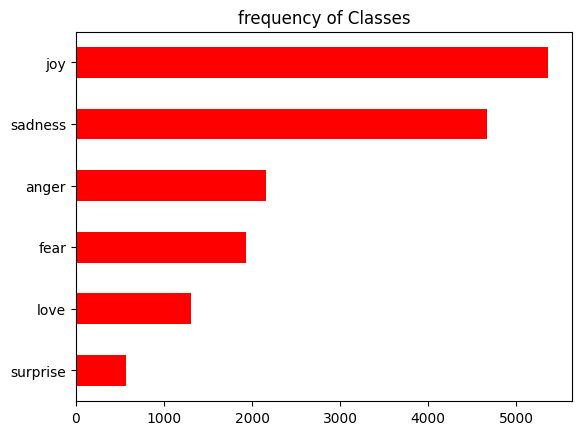

In [12]:
df['label_name'].value_counts(ascending=True).plot.barh(color='red')
plt.title('frequency of Classes')
plt.show()

## Maximum Context Size 확인
- 우리가 사용할 DistilBERT의 Max_length는 512 token

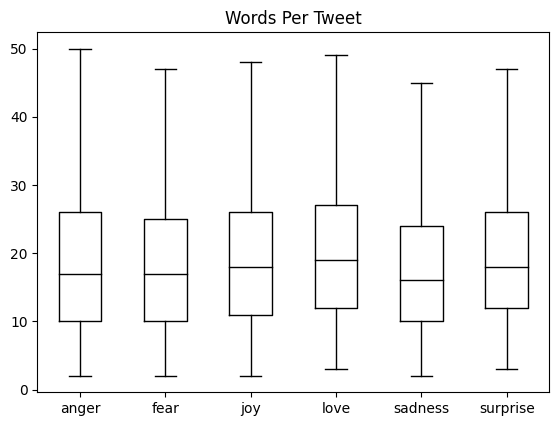

In [13]:
df["Words Per Tweet"] = df["text"].str.split().apply(len)
df.boxplot("Words Per Tweet", by="label_name", grid=False,
           showfliers=False, color="black")

plt.suptitle("")
plt.xlabel("")
plt.show()

위의 그래프를 보면 각 감정의 길이는 15개 정도의 단어임을 알 수 있다.

이는 가장 긴 트윗도 DistilBERT의 Max_length보다 더 작음을 알 수 있다.

- 만약 Max_length보다 길면, crop을 해야하는데, 이는 중요정보가 있는경우, 손실이 발생할 수 있다.

In [14]:
emotions.reset_format()

## 텍스트에서 토큰으로

### 문자 토큰

In [15]:
text = "Tokenizing text is a core task of NLP."
tokenized_text = list(text)
print(tokenized_text)

['T', 'o', 'k', 'e', 'n', 'i', 'z', 'i', 'n', 'g', ' ', 't', 'e', 'x', 't', ' ', 'i', 's', ' ', 'a', ' ', 'c', 'o', 'r', 'e', ' ', 't', 'a', 's', 'k', ' ', 'o', 'f', ' ', 'N', 'L', 'P', '.']


In [16]:
token2idx = {ch: idx for idx, ch in enumerate(sorted(set(tokenized_text)))}
print(token2idx)

{' ': 0, '.': 1, 'L': 2, 'N': 3, 'P': 4, 'T': 5, 'a': 6, 'c': 7, 'e': 8, 'f': 9, 'g': 10, 'i': 11, 'k': 12, 'n': 13, 'o': 14, 'r': 15, 's': 16, 't': 17, 'x': 18, 'z': 19}


In [17]:
input_ids = [token2idx[token] for token in tokenized_text]
print(input_ids)

[5, 14, 12, 8, 13, 11, 19, 11, 13, 10, 0, 17, 8, 18, 17, 0, 11, 16, 0, 6, 0, 7, 14, 15, 8, 0, 17, 6, 16, 12, 0, 14, 9, 0, 3, 2, 4, 1]


In [18]:
categorical_df = pd.DataFrame(
    {"Name": ["Bumblebee", "Optimus Prime", "Megatron"], "Label ID": [0,1,2]})
categorical_df

,Name,Label ID
0,Bumblebee,0
1,Optimus Prime,1
2,Megatron,2


In [21]:
# 위의 방식의 경우, 이름간의 가상의 순서가 만들어진다는 문제
# 따라서 이 category마다 새로운 열을 만들어 카테고리에 해당하면 1할당

pd.get_dummies(categorical_df["Name"])

,Bumblebee,Megatron,Optimus Prime
0,1,0,0
1,0,0,1
2,0,1,0


In [22]:
import torch.nn.functional as F

input_ids = torch.tensor(input_ids)
one_hot_encodings = F.one_hot(input_ids, num_classes=len(token2idx))
one_hot_encodings.shape

torch.Size([38, 20])

In [23]:
print(f"토큰: {tokenized_text[0]}")
print(f"텐서 인덱스: {input_ids[0]}")
print(f"원-핫 인코딩: {one_hot_encodings[0]}")

토큰: T
텐서 인덱스: 5
원-핫 인코딩: tensor([0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])


In [24]:
F.one_hot(torch.tensor([0,2]), num_classes=11).shape

torch.Size([2, 11])

### 단어 토큰화

In [26]:
tokenized_text = text.split()
print(tokenized_text)

['Tokenizing', 'text', 'is', 'a', 'core', 'task', 'of', 'NLP.']


### 부분단어 토큰화

In [27]:
from transformers import AutoTokenizer

# AutoTokenize는 자동으로 모델에 해당하는 토크나이저를 빠르게 로드한다.

model_ckpt = "distilbert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_ckpt)

In [28]:
encoded_text = tokenizer(text)
print(encoded_text)

{'input_ids': [101, 19204, 6026, 3793, 2003, 1037, 4563, 4708, 1997, 17953, 2361, 1012, 102], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}


In [29]:
tokens = tokenizer.convert_ids_to_tokens(encoded_text.input_ids)
print(tokens)

['[CLS]', 'token', '##izing', 'text', 'is', 'a', 'core', 'task', 'of', 'nl', '##p', '.', '[SEP]']


In [30]:
print(tokenizer.convert_tokens_to_string(tokens))

[CLS] tokenizing text is a core task of nlp. [SEP]


In [31]:
tokenizer.vocab_size

30522

In [32]:
tokenizer.model_max_length

512

In [33]:
tokenizer.model_input_names

['input_ids', 'attention_mask']

### 전체 데이터셋 토큰화하기

In [34]:
def tokenize(batch):
    return tokenizer(batch["text"], padding=True, truncation=True)

In [35]:
print(tokenize(emotions["train"][:2]))

{'input_ids': [[101, 1045, 2134, 2102, 2514, 26608, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [101, 1045, 2064, 2175, 2013, 3110, 2061, 20625, 2000, 2061, 9636, 17772, 2074, 2013, 2108, 2105, 2619, 2040, 14977, 1998, 2003, 8300, 102]], 'attention_mask': [[1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]]}


In [36]:
tokens2ids = list(zip(tokenizer.all_special_tokens, tokenizer.all_special_ids))
data = sorted(tokens2ids, key=lambda x : x[-1])
df = pd.DataFrame(data, columns=["Special Token", "Special Token ID"])
df.T

,0,1,2,3,4
Special Token,[PAD],[UNK],[CLS],[SEP],[MASK]
Special Token ID,0,100,101,102,103


<img alt="attention-mask" caption="For each batch, the input sequences are padded to the maximum sequence length in the batch; the attention mask is used in the model to ignore the padded areas of the input tensors" src="https://github.com/rickiepark/nlp-with-transformers/blob/main/images/chapter02_attention-mask.png?raw=1" id="attention-mask"/>

In [39]:
emotions_encoded = emotions.map(tokenize, batched=True, batch_size=None)

print(emotions_encoded["train"].column_names)

['text', 'label', 'input_ids', 'attention_mask']


## 텍스트 분류 모델 훈련하기

<img alt="encoder-classifier" caption="The architecture used for sequence classification with an encoder-based transformer; it consists of the model's pretrained body (blue) combined with a custom classification head (orange)" src="https://github.com/rickiepark/nlp-with-transformers/blob/main/images/chapter02_encoder-classifier.png?raw=1" id="encoder-classifier"/>

### 트랜스포머를 특성 추출기로 사용하기

<img alt="encoder-features" caption="In the feature-based approach, the DistilBERT model is frozen and just provides features for a classifier" src="https://github.com/rickiepark/nlp-with-transformers/blob/main/images/chapter02_encoder-feature-based.png?raw=1" id="encoder-features"/>

#### 사전 훈련된 모델 사용하기

# Text Classification Model Train
- transformer를 feature extraction으로 사용
- AutoModel클래스에서 from_pretrained()메서드 사용

In [40]:
from transformers import AutoModel

model_ckpt = "distilbert-base-uncased"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = AutoModel.from_pretrained(model_ckpt).to(device)

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_transform.bias', 'vocab_projector.bias', 'vocab_transform.weight', 'vocab_layer_norm.bias', 'vocab_layer_norm.weight']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


#### 마지막 hidden state 추출
- token을 pytorch tensor로 변환
- tokenizer에 return_tensor='pt' 매개변수를 지정

In [41]:
text = "this is a test"
inputs = tokenizer(text, return_tensors="pt")

print(f"입력 텐서 크기: {inputs['input_ids'].size()}")
# 결과 텐서: [batch_size, n_tokens]를 의미

입력 텐서 크기: torch.Size([1, 6])


In [42]:
inputs = {k:v.to(device) for k,v in inputs.items()}

# gradient 자동계산 비활성화로 메모리양을 줄임(추론 시 유리)
with torch.no_grad():
    outputs = model(**inputs)
print(outputs)

BaseModelOutput(last_hidden_state=tensor([[[-0.1565, -0.1862,  0.0528,  ..., -0.1188,  0.0662,  0.5470],
         [-0.3575, -0.6484, -0.0618,  ..., -0.3040,  0.3508,  0.5221],
         [-0.2772, -0.4459,  0.1818,  ..., -0.0948, -0.0076,  0.9958],
         [-0.2841, -0.3917,  0.3753,  ..., -0.2151, -0.1173,  1.0526],
         [ 0.2661, -0.5094, -0.3180,  ..., -0.4203,  0.0144, -0.2149],
         [ 0.9441,  0.0112, -0.4714,  ...,  0.1439, -0.7288, -0.1619]]],
       device='cuda:0'), hidden_states=None, attentions=None)


In [43]:
outputs.last_hidden_state.size()
# [batch_size, n_tokens, hidden_dim]을 의미
# 즉, 6개의 입력토큰마다 768차원의 벡터가 반환

torch.Size([1, 6, 768])

In [44]:
# 문자열의 마지막 hidden state를 만들어 위의 벡터를 저장해보자.
def extract_hidden_states(batch):
    # 모델 입력을 GPU로.
    inputs = {k:v.to(device) for k,v in batch.items()
              if k in tokenizer.model_input_names}

    # 마지막 은닉 상태를 추출.
    with torch.no_grad():
        last_hidden_state = model(**inputs).last_hidden_state

    # [CLS] 토큰에 대한 벡터를 반환.
    return {"hidden_state": last_hidden_state[:,0].cpu().numpy()}

In [45]:
emotions_encoded.set_format("torch", columns=["input_ids", "attention_mask", "label"])

In [46]:
emotions_hidden = emotions_encoded.map(extract_hidden_states, batched=True)

Map:   0%|          | 0/16000 [00:00<?, ? examples/s]

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

In [47]:
emotions_hidden["train"].column_names

['text', 'label', 'input_ids', 'attention_mask', 'hidden_state']

#### 특성 행렬 만들기

In [49]:
X_train = np.array(emotions_hidden["train"]["hidden_state"])
X_val = np.array(emotions_hidden["validation"]["hidden_state"])
y_train = np.array(emotions_hidden["train"]["label"])
y_val = np.array(emotions_hidden["validation"]["label"])

X_train.shape, X_val.shape

((16000, 768), (2000, 768))

#### trainset 시각화

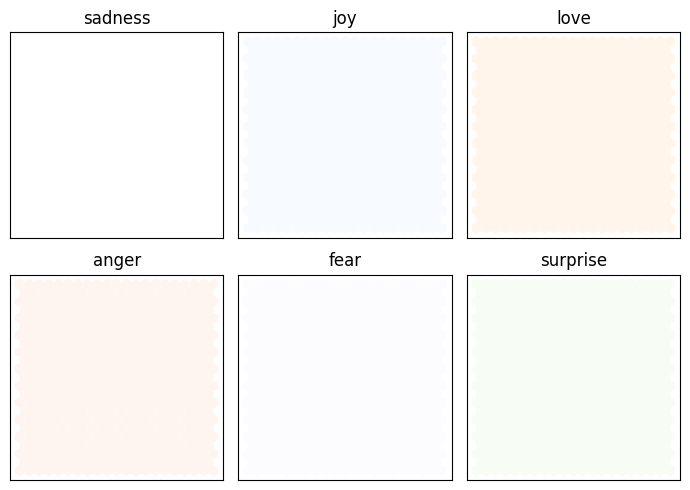

In [66]:
fig, axes = plt.subplots(2, 3, figsize=(7,5))
axes = axes.flatten()
cmaps = ["Greys", "Blues", "Oranges", "Reds", "Purples", "Greens"]
labels = emotions["train"].features["label"].names

for i, (label, cmap) in enumerate(zip(labels, cmaps)):
    df_emb_sub = df_emb.query(f"label == {i}")
    axes[i].hexbin(df_emb_sub["X"], df_emb_sub["Y"], cmap=cmap,
                   gridsize=20, linewidths=(0,))
    axes[i].set_title(label)
    axes[i].set_xticks([]), axes[i].set_yticks([])

plt.tight_layout()
plt.show()

#### 간단한 분류 모델 훈련하기

In [68]:
# 수렴을 보장하기 위해 `max_iter`를 증가시킵니다.
from sklearn.linear_model import LogisticRegression

lr_clf = LogisticRegression(max_iter=3000)
lr_clf.fit(X_train, y_train)

LogisticRegression(max_iter=3000)

In [70]:
lr_clf.score(X_val, y_val)
# 정확도가 약 63%
# 이는 불균형 다중클래스 dataset이기 때문!!

0.633

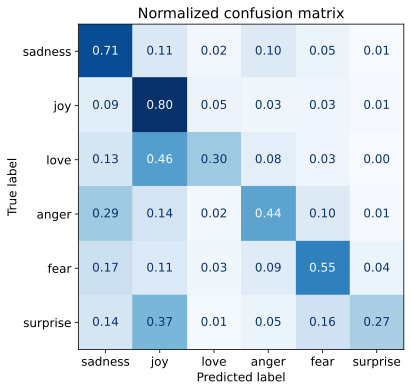

In [ ]:
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix

def plot_confusion_matrix(y_preds, y_true, labels):
    cm = confusion_matrix(y_true, y_preds, normalize="true")
    fig, ax = plt.subplots(figsize=(6, 6))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
    disp.plot(cmap="Blues", values_format=".2f", ax=ax, colorbar=False)
    plt.title("Normalized confusion matrix")
    plt.show()

y_preds = lr_clf.predict(X_valid)
plot_confusion_matrix(y_preds, y_valid, labels)

## 트랜스포머 미세 튜닝하기
- transformer를 end2end로 fine-tuning하기.
- hidden state를 고정된 특성으로 사용하지 않음
- 아래 그림처럼 전체 모델을 훈련한다.

<img alt="encoder-tuning" caption="When using the fine-tuning approach the whole DistilBERT model is trained along with the classification head" src="https://github.com/rickiepark/nlp-with-transformers/blob/main/images/chapter02_encoder-fine-tuning.png?raw=1" id="encoder-tuning"/>

#### 사전 훈련된 모델 로드하기

In [71]:
from transformers import AutoModelForSequenceClassification

num_labels = 6
model = (AutoModelForSequenceClassification.from_pretrained(model_ckpt, num_labels=num_labels).to(device))

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_transform.bias', 'vocab_projector.bias', 'vocab_transform.weight', 'vocab_layer_norm.bias', 'vocab_layer_norm.weight']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight', 'classifier.

#### Metric 정의

In [72]:
from sklearn.metrics import accuracy_score, f1_score

def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    f1 = f1_score(labels, preds, average="weighted")
    acc = accuracy_score(labels, preds)
    return {"accuracy": acc, "f1": f1}

#### 모델 훈련하기

In [ ]:
from huggingface_hub import notebook_login

notebook_login()

In [79]:
!pip install transformers[torch]

In [ ]:
from transformers import Trainer, TrainingArguments

batch_size = 64
logging_steps = len(emotions_encoded["train"]) // batch_size
model_name = f"{model_ckpt}-finetuned-emotion"

training_args = TrainingArguments(output_dir=model_name,
                                  num_train_epochs=2,
                                  learning_rate=2e-5,
                                  per_device_train_batch_size=batch_size,
                                  per_device_eval_batch_size=batch_size,
                                  weight_decay=0.01,
                                  evaluation_strategy="epoch",
                                  disable_tqdm=False,
                                  logging_steps=logging_steps,
                                  push_to_hub=True,
                                  save_strategy="epoch",
                                  load_best_model_at_end=True,
                                  log_level="error")

In [ ]:
from transformers import Trainer

trainer = Trainer(model=model, args=training_args,
                  compute_metrics=compute_metrics,
                  train_dataset=emotions_encoded["train"],
                  eval_dataset=emotions_encoded["validation"],
                  tokenizer=tokenizer)
trainer.train();

Cloning https://huggingface.co/haesun/distilbert-base-uncased-finetuned-emotion into local empty directory.


Download file pytorch_model.bin:   0%|          | 1.39k/255M [00:00<?, ?B/s]

Download file runs/Sep04_00-42-37_d7cb327b0589/1662252292.2464943/events.out.tfevents.1662252292.d7cb327b0589.…

Download file training_args.bin: 100%|##########| 3.37k/3.37k [00:00<?, ?B/s]

Download file runs/Jul31_14-36-39_7c2acc53f4d0/events.out.tfevents.1659278477.7c2acc53f4d0.73.0: 100%|########…

Download file runs/Jan02_05-30-47_e4e4e3d27cc5/events.out.tfevents.1672637653.e4e4e3d27cc5.185.0: 100%|#######…

Download file runs/Jul31_14-36-39_7c2acc53f4d0/1659278477.776739/events.out.tfevents.1659278477.7c2acc53f4d0.7…

Clean file runs/Sep04_00-42-37_d7cb327b0589/1662252292.2464943/events.out.tfevents.1662252292.d7cb327b0589.110…

Download file runs/Sep04_00-42-37_d7cb327b0589/events.out.tfevents.1662252292.d7cb327b0589.1102.0: 100%|######…

Clean file training_args.bin:  30%|##9       | 1.00k/3.37k [00:00<?, ?B/s]

Download file runs/Jan02_05-30-47_e4e4e3d27cc5/1672637653.9897866/events.out.tfevents.1672637653.e4e4e3d27cc5.…

Clean file runs/Jul31_14-36-39_7c2acc53f4d0/events.out.tfevents.1659278477.7c2acc53f4d0.73.0:  21%|##        |…

Clean file runs/Jan02_05-30-47_e4e4e3d27cc5/events.out.tfevents.1672637653.e4e4e3d27cc5.185.0:  19%|#9        …

Clean file runs/Jul31_14-36-39_7c2acc53f4d0/1659278477.776739/events.out.tfevents.1659278477.7c2acc53f4d0.73.1…

Clean file runs/Sep04_00-42-37_d7cb327b0589/events.out.tfevents.1662252292.d7cb327b0589.1102.0:  19%|#9       …

Clean file runs/Jan02_05-30-47_e4e4e3d27cc5/1672637653.9897866/events.out.tfevents.1672637653.e4e4e3d27cc5.185…

Clean file pytorch_model.bin:   0%|          | 1.00k/255M [00:00<?, ?B/s]

/usr/local/lib/python3.8/dist-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.846000,0.313323,0.903000,0.900394
2,0.244900,0.215524,0.925500,0.925631


In [ ]:
preds_output = trainer.predict(emotions_encoded["validation"])

In [ ]:
preds_output.metrics

{'test_loss': 0.21552352607250214,
 'test_accuracy': 0.9255,
 'test_f1': 0.9256314817870995,
 'test_runtime': 3.993,
 'test_samples_per_second': 500.878,
 'test_steps_per_second': 8.014}

In [ ]:
y_preds = np.argmax(preds_output.predictions, axis=1)

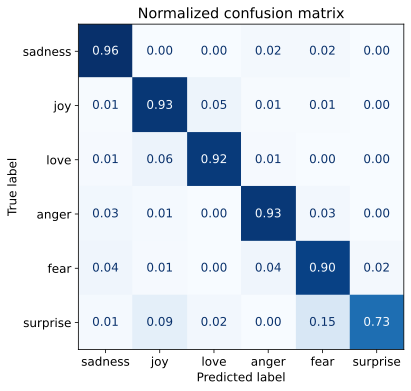

In [ ]:
plot_confusion_matrix(y_preds, y_valid, labels)

#### 오류 분석

In [ ]:
from torch.nn.functional import cross_entropy

def forward_pass_with_label(batch):
    # 모든 입력 텐서를 모델과 같은 장치로 이동합니다.
    inputs = {k:v.to(device) for k,v in batch.items()
              if k in tokenizer.model_input_names}

    with torch.no_grad():
        output = model(**inputs)
        pred_label = torch.argmax(output.logits, axis=-1)
        loss = cross_entropy(output.logits, batch["label"].to(device),
                             reduction="none")

    # 다른 데이터셋 열과 호환되도록 출력을 CPU로 옮깁니다.
    return {"loss": loss.cpu().numpy(),
            "predicted_label": pred_label.cpu().numpy()}

In [ ]:
# 데이터셋을 다시 파이토치 텐서로 변환합니다.
emotions_encoded.set_format("torch",
                            columns=["input_ids", "attention_mask", "label"])
# 손실 값을 계산합니다.
emotions_encoded["validation"] = emotions_encoded["validation"].map(
    forward_pass_with_label, batched=True, batch_size=16)

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

In [ ]:
emotions_encoded.set_format("pandas")
cols = ["text", "label", "predicted_label", "loss"]
df_test = emotions_encoded["validation"][:][cols]
df_test["label"] = df_test["label"].apply(label_int2str)
df_test["predicted_label"] = (df_test["predicted_label"]
                              .apply(label_int2str))

In [ ]:
df_test.sort_values("loss", ascending=False).head(10)

,text,label,predicted_label,loss
1950,i as representative of everything thats wrong ...,surprise,sadness,5.623446
1963,i called myself pro life and voted for perry w...,joy,sadness,5.619520
1801,i feel that he was being overshadowed by the s...,love,sadness,5.607580
1274,i am going to several holiday parties and i ca...,joy,sadness,5.604027
765,i feel super awkward and out of place right now,joy,sadness,5.509608
1870,i guess i feel betrayed because i admired him ...,joy,sadness,5.346349
465,i would eventually go in to these stores but i...,joy,fear,5.260897
882,i feel badly about reneging on my commitment t...,love,sadness,4.995311
1509,i guess this is a memoir so it feels like that...,joy,fear,4.617338
1111,im lazy my characters fall into categories of ...,joy,fear,4.522757


In [ ]:
df_test.sort_values("loss", ascending=True).head(10)

,text,label,predicted_label,loss
1873,i feel practically virtuous this month i have ...,joy,joy,0.015129
19,i had lunch with an old friend and it was nice...,joy,joy,0.015413
1012,i definitely succumbed to pre holiday sales bu...,joy,joy,0.015463
1226,im feeling terrific and in great shape im opti...,joy,joy,0.015629
632,i feel he is an terrific really worth bet,joy,joy,0.015699
329,i have had my treasury selection on the front ...,joy,joy,0.015712
1688,i feel very very rich and fulfilled and a part...,joy,joy,0.015743
1513,i have also been getting back into my gym rout...,joy,joy,0.015774
222,i am at day and i am feeling terrific,joy,joy,0.015783
1901,i believe my ground game is where i feel most ...,joy,joy,0.015839


#### 모델 저장 및 공유

In [ ]:
trainer.push_to_hub(commit_message="Training completed!")

remote: Scanning LFS files of refs/heads/main for validity...        
remote: LFS file scan complete.        
To https://huggingface.co/haesun/distilbert-base-uncased-finetuned-emotion
   b9712fd..0a72b17  main -> main

remote: LFS file scan complete.        
To https://huggingface.co/haesun/distilbert-base-uncased-finetuned-emotion
   b9712fd..0a72b17  main -> main

To https://huggingface.co/haesun/distilbert-base-uncased-finetuned-emotion
   0a72b17..03811cd  main -> main

   0a72b17..03811cd  main -> main



'https://huggingface.co/haesun/distilbert-base-uncased-finetuned-emotion/commit/0a72b17536e9934a6dae5f5335d31184534b1d49'

In [ ]:
from transformers import pipeline

model_id = "chan/distilbert-base-uncased-finetuned-emotion"
classifier = pipeline("text-classification", model=model_id)

In [ ]:
custom_tweet = "I saw a movie today and it was really good."
preds = classifier(custom_tweet, return_all_scores=True)

/usr/local/lib/python3.8/dist-packages/transformers/pipelines/text_classification.py:104: UserWarning: `return_all_scores` is now deprecated,  if want a similar funcionality use `top_k=None` instead of `return_all_scores=True` or `top_k=1` instead of `return_all_scores=False`.
  warnings.warn(


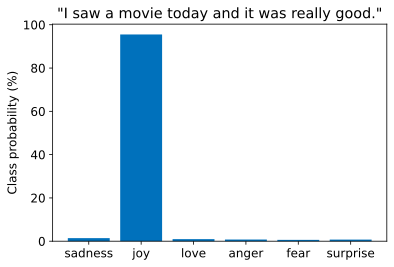

In [ ]:
preds_df = pd.DataFrame(preds[0])
plt.bar(labels, 100 * preds_df["score"], color='C0')
plt.title(f'"{custom_tweet}"')
plt.ylabel("Class probability (%)")
plt.show()

## 결론